# Momentum Keystone Project

__Goal:__

- We backtest to find optimal SMA/LMA period
- We use a momentum strategy if it outperforms long-only approach (in backtesting)
- We execute trades

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime

#### We assign initial variables

In [20]:
stock = "MSFT" # our chosen stock
td_year = 252 # assumed trading days per year
sma = 50 # small moving average (short) if not optimized
lma = 200 # small moving average (long) if not optimized
shares = 10 #number of shares of stock we purchase
today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))

# The following are minimum / maximum values for the sma and lma used for our OPTIONAL optimizer. Leave random/blank if not running optimzer.

smamin = 10
smamax = 50
lmamin = 100
lmamax = 252

#### We import and prepare stock data

In [21]:
stockdata = yf.download(tickers = stock).Close.to_frame()
stockdata.rename(columns = {"Close":"Price"}, inplace = True)

[*********************100%***********************]  1 of 1 completed


#### We have an (optional) moving average optimizer

In [16]:
def optimzer(SMA):
    df = stockdata.copy()
    df["Returns"] = np.log(df["Price"].div(df["Price"].shift(1))).dropna()
    df["SMA"] = df.Price.rolling(int(SMA[0])).mean()
    df["LMA"] = df.Price.rolling(int(SMA[1])).mean()
    df.dropna(inplace = True)
    
    df["Position"] = np.where(df["SMA"]<df["LMA"], -1, 1)
    df["Strategy_Returns"] = df.Returns * df.Position.shift(1)
    df.dropna(inplace = True)
    
    return -df[["Returns", "Strategy_Returns"]].sum().apply(np.exp)[-1] # negative multiple -> minimize (as scipy can only minimize)

from scipy.optimize import brute
optimal_averages = brute(optimzer, ((smamin, smamax, 1), (lmamin, lmamax, 1)))
sma = int(optimal_averages[0])
lma = int(optimal_averages[1])

#### We prepare our stock data

In [22]:
stockdata["Returns"] = np.log(stockdata["Price"].div(stockdata["Price"].shift(1))).dropna()
stockdata["SMA"] = stockdata.Price.rolling(sma).mean()
stockdata["LMA"] = stockdata.Price.rolling(lma).mean()
stockdata.dropna(inplace = True)
stockdata["Position"] = np.where(stockdata["SMA"]<stockdata["LMA"], -1, 1)
stockdata["Strategy_Returns"] = stockdata.Returns * stockdata.Position.shift(1)

#### We calculate returns on long-only strategy VS our optimsed strategy

In [28]:
summary = pd.DataFrame(index=[stock + " Long Only"])
summary["ann. Risk"] = stockdata.Returns.std() * np.sqrt(td_year)
summary["CAGR"] = np.exp(stockdata.Returns.mean() * td_year) - 1
strategy_ann_risk = stockdata.Strategy_Returns.std() * np.sqrt(td_year)
strategy_cagr = np.exp(stockdata.Strategy_Returns.mean() * td_year) - 1
summary.loc[stock + " Stategy"] = [strategy_ann_risk, strategy_cagr]

if summary.loc[stock + " Stategy", "CAGR"] > summary.loc[stock + " Long Only", "CAGR"]:
    trade_strategy = "Strategy"
else:
    trade_strategy = "Long"

#### The following plots our returns over time for visual comparison

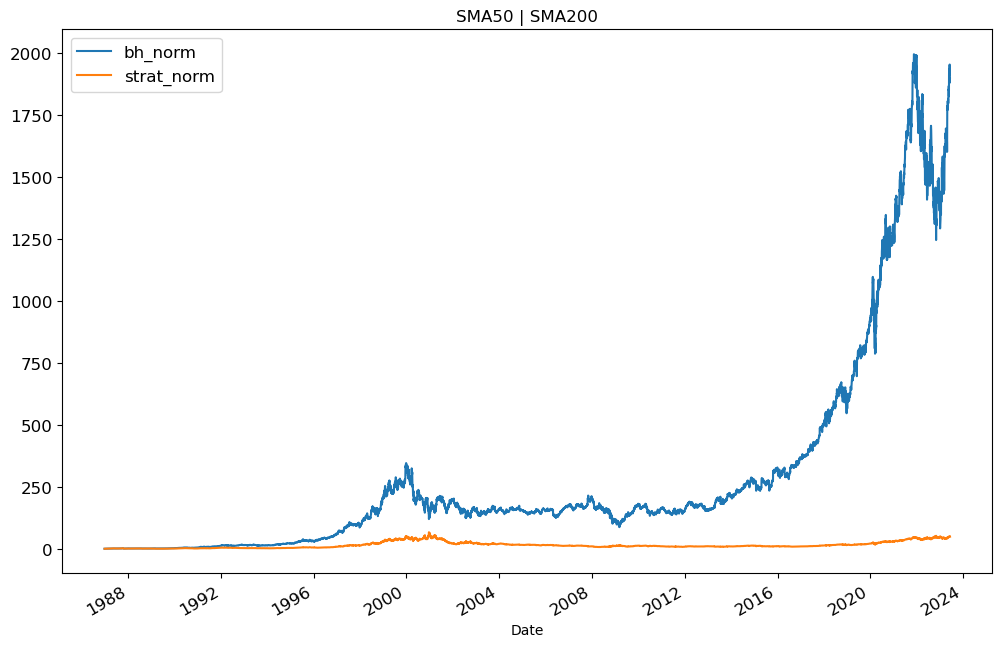

In [24]:
import matplotlib.pyplot as plt

stockdata["bh_norm"] = stockdata["Returns"].cumsum().apply(np.exp)
stockdata["strat_norm"] = stockdata["Strategy_Returns"].cumsum().apply(np.exp)
stockdata[["bh_norm", "strat_norm"]].plot(figsize = (12, 8), title = "SMA{} | SMA{}".format(sma, lma), fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

#### We initiliase our trading tools

In [ ]:
from ib_insync import *
util.startLoop()
ib = IB()
ib.connect()

#### We set up our trades (if any)

In [ ]:
#### We initiliase our trading toolspos = ib.positions()
df = util.df(pos)
if df is not None:
    df["symbol"] = df.contract.apply(lambda x: x.symbol)
    df["conID"] = df.contract.apply(lambda x: x.conId)
else: 
    df = pd.DataFrame(columns = ["symbol", "position", "conID"])

In [ ]:
contract = Stock(stock, "SMART", "USD")
cds = ib.reqContractDetails(contract)
conID = cds[0].contract.conId
current_pos = df[df.conID == conID]

if len(current_pos) == 0:
    actual = 0
else: 
    actual = current_pos.position.iloc[0]
    
position = stockdata.Position.iloc[-1]
if trade_strategy == "Strategy":
    trades = (position*shares) - actual
else:
    if actual == 0:
        trades = (position#### We set up our trades (if any)*shares) - actual 
    else:
        trades = 0

#### We execute our trades (if any)

In [ ]:
if trades > 0:
    side = "BUY"
    order = MarketOrder(side, abs(trades))
    trade = ib.placeOrder(contract, order)
    while not trade.isDone():
        ib.waitOnUpdate()
    if trade.orderStatus.status == "Filled":
        print("{} {} {} @ {}".format(side, trade.orderStatus.filled, stock, trade.orderStatus.avgFillPrice))
    else:
        print("{} {} failed.".format(side, stock))
elif trades < 0:
    side = "SELL"
    order = MarketOrder(side, abs(trades))
    trade = ib.placeOrder(contract, order)
    while not trade.isDone():
        ib.waitOnUpdate()
    if trade.orderStatus.status == "Filled":
        print("{} {} {} @ {}".format(side, trade.orderStatus.filled, stock, trade.orderStatus.avgFillPrice))
    else:
        
        print("{} {} failed.".format(side, stock#### We set up our trades (if any)))
else:
    print("No Trades required.")

In [ ]:
ib.disconnect()